# Pohyb částic v polích (v Pythonu)

In [1]:
# we will need the numpy library for some operations with vectors and matrices
import numpy as np
# the ode function from scipy.integrate will be used for integrating the system of ordinary differential equations
from scipy.integrate import ode
# we will also need some elliptic integrals
from scipy.special import ellipk, ellipe

## 1. Formulace problému a potřebné knihovny

V tomto cvičení si ukážeme, jak pomocí pythonu a knihovny scipy numericky integrovat pohybovou rovnici pro částici v zadaném silovém poli a následně si vykreslit její trajektorii. V tomto cvičení budeme vždy uvažovat částici, které má nenulový elektrický náboj a pohybuje se ve vnějších elektrických a magnetických polích. Její pohybová rovnice má tedy obecně tvar

$m \mathbf{a} = q \left( \mathbf{E} + \mathbf{v} \times \mathbf{B} \right)$

a protože $\mathbf{a}(t) = \ddot{\mathbf{r}}(t)$ a $\mathbf{v}(t) = \dot{\mathbf{r}}(t)$, můžeme tuto pohybovou rovnici přepsat jako soustavu tří obyčejných diferenciálních rovnic (ODE) druhého řádu pro polohu částice $\mathbf{r}(t)$

$m \ddot{\mathbf{r}} = q \left( \mathbf{E} + \mathbf{\dot{r}} \times \mathbf{B} \right)$

**Našim cílem bude, za zadaných polí, která můžou obecně mít složitou závislost na čase i souřadnici, $\mathbf{B}(\mathbf{r}, t)$, $\mathbf{E}(\mathbf{r}, t)$ a za zadaných počátečních podmínek $\mathbf{r}(t=0)$ a $\mathbf{v}(t=0)$ vyřešit tuto pohybovou rovnici a vykreslit trajektorii čásice ve 3D geometrii případně 2D řezech.**

<span style="color: #d6653b; font-weight:bold; font-size: 18px; ">Úkol 1:</span> Najděte, zda v knihovnách NumPy a SciPy existuje funkce na řešení soustavy obyčejných diferenciálních rovnic. Zjistěte, zda tato funkce umožňuje řešení ODE druhého řádu případně v jakém formátu očekává vstup.

**Odpověď:** Nejde, scipy.integrate.ode() očekává, že soustava bude ve tvaru $\dot{\mathbf{q}}(t) = f(t, \mathbf{q})$ https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html .
Musíme tedy naši soustavu tří ODE druhého řádu přepsat jako soustavu šesti ODE prvního řádu, což uděláme tak, že jako proměnné zvolíme nejen $\mathbf{r}(t)$, ale i $\mathbf{v}(t)$ a řešíme soustavu provázaných ODE

$m \dot{\mathbf{v}} = q \left( \mathbf{E} + \mathbf{v} \times \mathbf{B} \right)$<br/>
$\dot{\mathbf{r}} = \mathbf{v}$

## 2. Funkce generující externí pole

Protože jsme si slíbili, že budeme simulovat pohyb částice ve složitých externích polích, budeme nejprve potřebovat funkci, která nám bude dávát $\mathbf{B}(t, \mathbf{r})$ a $\mathbf{E}(t, \mathbf{r})$, tedy externí pole jako funkce času a vektoru polohy.

<img src="https://www.ux1.eiu.edu/~cfadd/1360/30MagSrcs/Images/Fig30.06.jpg" />

In [2]:
def E(t,r):
    """This is the function returning the vector of the electric field for
    a specific time t and position vector r.
    In this simple case, the function returns a constant vector"""
    Ex = 0
    Ey = 0
    Ez = 1e-7
    
    return (Ex, Ey, Ez)

In [3]:
def B(t,r):
    """This is the function returning the vector of the electric field for
    a specific time t and position vector r.
    In this simple case, the function returns a constant vector"""
    Bx = 0
    By = 0
    Bz = 1e-6
    
    return (Bx, By, Bz)

## 3. Funkce dávající pravé strany pohybové rovnice

Jako další potřebujeme funkci $f$ která je taková, že, že $\dot{\mathbf{q}}(t) = f(t, \mathbf{q})$, protože scipy.integrate.ode() umí soustavy vyřešit jen v tomto konkrétním tvaru. 

Tato funkce $f(t, \mathbf{q})$ nám tedy jinými slovy dává pravé strany naší soustavy 6 ODE. Připomeňme si také, že $\mathbf{q}$ je vektor obsahující všech 6 našich nezávislých proměnných

$\mathbf{q} = (x,y,z,v_x,v_y,v_z)$

In [4]:
def rhs(t, q):
    """This function describes the problem to be integrated - it gives the right hand sides of our system of 6 ODEs.
    This function takes two arguments:
        t -- time
        q -- vector of independent variables (x,y,z,vx,vy,vz)
    And it returns a single vector:
        dqdt -- time derivative of the vector q
    """
    qp = -1.6e-19
    mp = 9.103e-31
    
    r = q[0:3]
    vx, vy, vz = q[3:6]
    
    Ex, Ey, Ez = E(t,r)
    Bx, By, Bz = B(t,r)
    
    dxdt, dydt, dzdt = q[3:6]
    
    dvxdt = qp/mp * (Ex + vy*Bz - vz*By)
    dvydt = qp/mp * (Ey + vz*Bx - vx*Bz)
    dvzdt = qp/mp * (Ez + vx*By - vy*Bx)
    
    dqdt = [dxdt, dydt, dzdt, dvxdt, dvydt, dvzdt]
    
    return dqdt

## 4. Integrace pohybové rovnice

### Inicializace diferenciální rovnice a první časový krok

Konečně máme (skoro) vše potřebné k tomu, abychom mohli integrovat naši pohybovou rovnici. Náš systém 6 ODE budeme integrovat v čase a budeme si tedy pro každou z veličin (x,y,z,vx,vy,vz) potřebovat počáteční podmínku.

In [5]:
t0 = 0 # initial time
q0 = [0, 0, -0.03, 0, 1000, 0] # initial values of coordinate and velocity respectively

Nyní si zkusíme ručně udělat pár časových kroků. Neprve musíme inicializovat soustavu ODE tím, že zavoláme funkci ode() a jako argument jí předáme naši funkci *rhs()*, tedy funkci vracející pravé strany ODE.

In [6]:
r = ode(rhs) # We call the scipy.integrate.ode() function and pass it the rhs() function as argument

In [7]:
r.t

AttributeError: 'ode' object has no attribute 't'

Veškeré informace o našem systému difierenciálních rovnic jsou nyní jakýmsi způsobem uloženy v proměnné **r**. To, jak budeme s proměnnou **r** na dalších řádcích pracovat, berte prozatím jako "magické příkazy", více o tom jak fungují třídy a objekty si povíme v budoucnu. 

Počáteční podmínku naší soustavě ODE nastavíme pomocí následujícícho příkazu (jak možná vidíte, funkce set_initial_value() je jakoby "uvnitř" proměnné **r**)

In [8]:
r.set_initial_value(q0, t0) # then we set initial value of the independent variables and time

In [9]:
r.t

0

a když nyní chceme postoupit s řešením o určitý časový krok, zavoláme následující funkci, která udělá to že se posune z aktuálního času v naší soustavě ODE o časový krok 1e-8. Jakmile se řešení posune, vrátí tato funkce aktuální hodnotu vektoru $\mathbf{q}$ = (x,y,z,vx,vy,vz). Zkuste si funkci spustit několikrát, prípadně si vypište hodnotu r.t, abyste viděli, co se děje :-).

In [10]:
r.integrate(r.t+1e-8)

array([ -8.78830954e-09,   9.99999485e-06,  -3.00000000e-02,
        -1.75766140e+00,   9.99998455e+02,  -1.75766231e-04])

In [11]:
r.successful()

True

### Automatizace řešení ODE

Pokud chceme náš systém ODE integrovat na určitém intervalu, musíme vědět, odkud kam integrujeme a s jakým časovým krokem. Uložíme si tedy do proměnných konečný čas **tf** a časový krok **dt**

In [12]:
tf = 8e-5 # final time 
dt = 5e-9 # time step

Také budeme potřebovat počáteční podmínku

In [13]:
t0 = 0 # initial time
q0 = [0, 0, 0, 0, 1000, 0] # initial values of coordinate and velocity respectively

A budeme potřebovat i nějaké objekty - konkrétně numPy pole, kam budeme průběžně ukládat výsledky.

In [14]:
times = np.array([t0]) # numpy array where we are going to store time steps that the simulation makes
results = np.array(q0) # numpy array where we are going to store positions and velocities.

Potom už budeme postupovat velmi podobně. Nejprve inicializujeme systém ODE a nastavíme počáteční podmínku a potom začněme dělat časové kroky s tím, že po každém kroku si aktuální řešení připojíme do polí times a results.

In [15]:
# The following four lines are solving the differential equation 
r = ode(rhs) # We call the scipy.integrate.ode() function and pass it the rhs() function as argument
r.set_initial_value(q0, t0) # then we set initial value of the independent variables and time

# And finally, we run a while loop until we reach the final time.
while r.successful() and r.t < tf: 
    times = np.vstack([times, r.t+dt])
    results = np.vstack([results, r.integrate(r.t+dt)])

In [16]:
r.successful()

True

In [17]:
times[0:6]

array([[  0.00000000e+00],
       [  5.00000000e-09],
       [  1.00000000e-08],
       [  1.50000000e-08],
       [  2.00000000e-08],
       [  2.50000000e-08]])

In [18]:
results[0:6]

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+03,   0.00000000e+00],
       [ -2.19707775e-09,   4.99999936e-06,  -2.19707789e-13,
         -8.78831041e-01,   9.99999614e+02,  -8.78831155e-05],
       [ -8.78830730e-09,   9.99999485e-06,  -8.78831155e-13,
         -1.75766140e+00,   9.99998455e+02,  -1.75766231e-04],
       [ -1.97736789e-08,   1.49999826e-05,  -1.97737010e-12,
         -2.63649041e+00,   9.99996524e+02,  -2.63649346e-04],
       [ -3.51531828e-08,   1.99999588e-05,  -3.51532462e-12,
         -3.51531738e+00,   9.99993821e+02,  -3.51532462e-04],
       [ -5.49268091e-08,   2.49999195e-05,  -5.49269472e-12,
         -4.39414163e+00,   9.99990346e+02,  -4.39415577e-04]])

Výše jsme použili smyčku typu while (angl. *while loop*). Tato smyčka je zajímavá tím, že běží a běží a běží a běží, dokud je splněna podmínka ve while smyčce. To znamená, že v našem případě bude smyčka pokračovat, pokud jsou splněny podmínky:
<ol>
<li>r.successful() vrátí hodnotu pravda/True</li>
<li>r.t je menší než naše hodnota finálního času **tf**</li>
</ol>

### Vykreslení trajektorie ve 3D

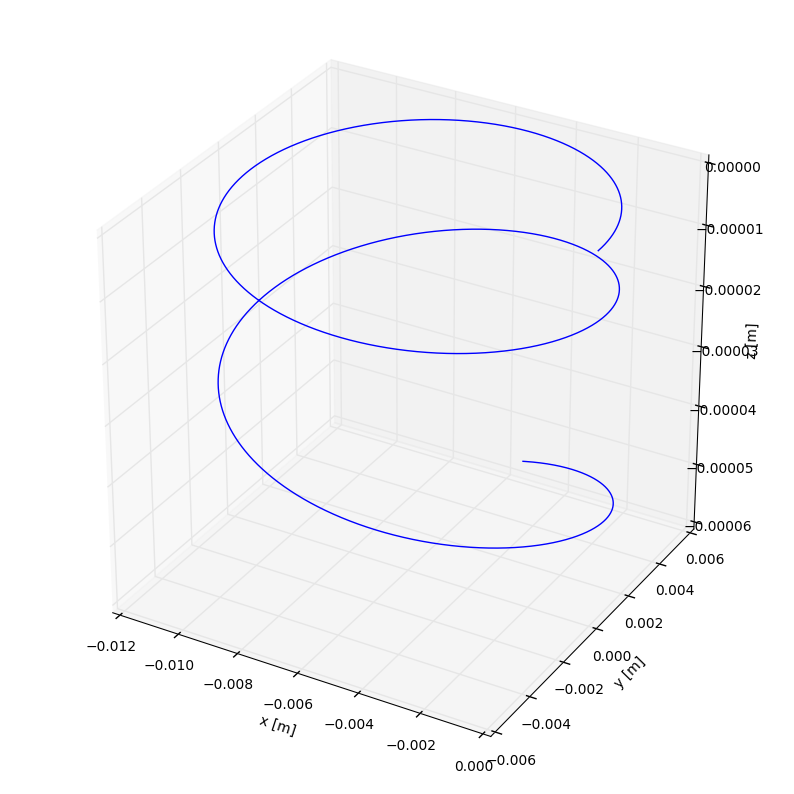

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.cla()
plt.clf()

# Firstly, we initialize the figure and the only thing we specify are its dimensions
fig = plt.figure(figsize=(10,10))
# Then, we create coordinate axes and by passing the projection='3d' keyword argument, we tell matplotlib
# that we will be making a 3D picture. If we need to make any modifications to the axes later,
# we will be modifying the "ax" object.
ax = fig.gca(projection='3d') 
# Now that matplotlib knows that we are going to plot 3D data, we can call our
# usual plot() function, but instead of pasing it (x,y) data, we pass it (x,y,z) data, very simple.
plt.plot(results[:,0], results[:,1], results[:,2]) 

# Here, we set axis labels
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

# And finally, we reveal the beautiful picture.
plt.show()

## Užitečný příklad - magnetické zrcadlo

Nyní si zkusíme zopakovat předchozí příklad, ale změníme výraz pro magnetické pole $\mathbf{B}(t,\mathbf{r})$. Konkrétně jej nahradíme analytickým výrazem pro magnetické pole proudové smyčky, jejíž osa je podél osy *z*.

https://github.com/ziky5/F4500_Pyhon_pro_fyziky/blob/master/lekce_05/B.ipynb

https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/20140002333.pdf

In [20]:
def B(t, r):
    """Returns magnetic field of a current loop in point r = (r1, r2, r3) and time t
    The expressions for the magnatic field of the current loop are taken from 
    [J. Simpson et al. Simple Analytic Expressions for the Magnetic Field of a Circular Current Loop. 
    Transactions on Magnetics (2001)]
    
    Arguments:
        r -- vector of position
        t -- time
        
    Returns:
        B -- vector of magnetic field components
    """
    x,y,z = r
    
    a = 0.03 # diameter of the solenoid in meters
    mu0 = 4*np.pi*1e-7 # vacuum permeability
    I = 10 # current in Amps
    #D = 0.1 # distance of two current loops
    C = mu0 * I / np.pi
    
    rho2 = np.power(x,2) + np.power(y,2)
    rho = np.sqrt(rho2)
    r2 = np.power(x,2) + np.power(y,2) + np.power(z,2)
    a2 = np.power(a, 2)
    alpha2 = a2 + r2 - 2*a*rho
    beta2 = a2 + r2 + 2*a*rho
    beta = np.sqrt(beta2)
    k2 = 1 - alpha2/beta2
    
    #print(ellipk(k2))
    #print(2 * alpha2 * beta * rho2)
    
    Bx = (C * x * z) / (2 * alpha2 * beta * rho2) * ( (a2 + r2) * ellipe(k2) - alpha2 * ellipk(k2) )
    By = Bx * y / x
    Bz = C / ( 2 * alpha2 * beta ) * ( (a2 - r2) * ellipe(k2) + alpha2 * ellipk(k2) )
    
    # Function diverges if x = y = 0, in which case we fix it.
    if x == 0 or y == 0:
        Bx, By = (0, 0)
    
    return (Bx, By, Bz)

### Počítání

In [21]:
tf = 5e-5 # final time 
dt = 5e-9 # time step

t0 = 0 # initial time
q0 = [0, 0, -0.03, 1000, 1000, 4500] # initial values of coordinate and velocity respectively

times = np.array([t0]) # numpy array where we are going to store time steps that the simulation makes
results = np.array(q0) # numpy array where we are going to store positions and velocities.

# The following lines are solving the differential equation 
r = ode(rhs) # We call the scipy.integrate.ode() function and pass it the rhs() function as argument
r.set_initial_value(q0, t0) # then we set initial value of the independent variables and time

# And finally, we run a while loop until we reach the final time.
while r.successful() and r.t < tf: 
    times = np.vstack([times, r.t+dt])
    results = np.vstack([results, r.integrate(r.t+dt)])

/home/ziky/.virtualenvs/plasmasolve3/lib/python3.4/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


### Vykreslení trajektorie ve 3D

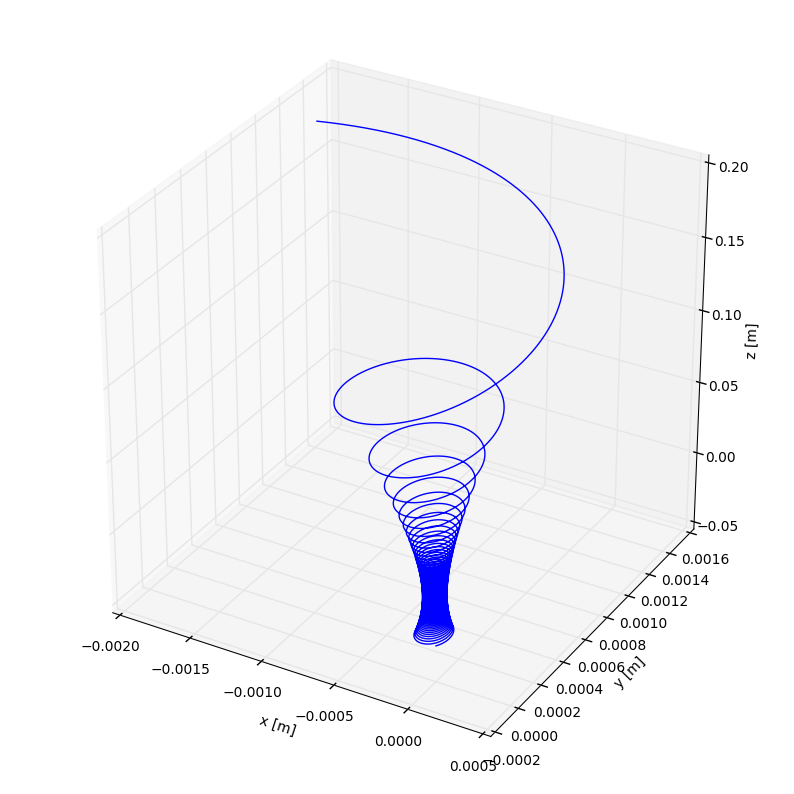

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Firstly, we initialize the figure and the only thing we specify are its dimensions
fig = plt.figure(figsize=(10,10))
# Then, we create coordinate axes and by passing the projection='3d' keyword argument, we tell matplotlib
# that we will be making a 3D picture. If we need to make any modifications to the axes later,
# we will be modifying the "ax" object.
ax = fig.gca(projection='3d') 
# Now that matplotlib knows that we are going to plot 3D data, we can call our
# usual plot() function, but instead of pasing it (x,y) data, we pass it (x,y,z) data, very simple.
plt.plot(results[:,0], results[:,1], results[:,2]) 

# Here, we set axis labels
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

# And finally, we reveal the beautiful picture.
plt.show()

### Vykreslení trajektorie ve 3D s obarvenou čárou

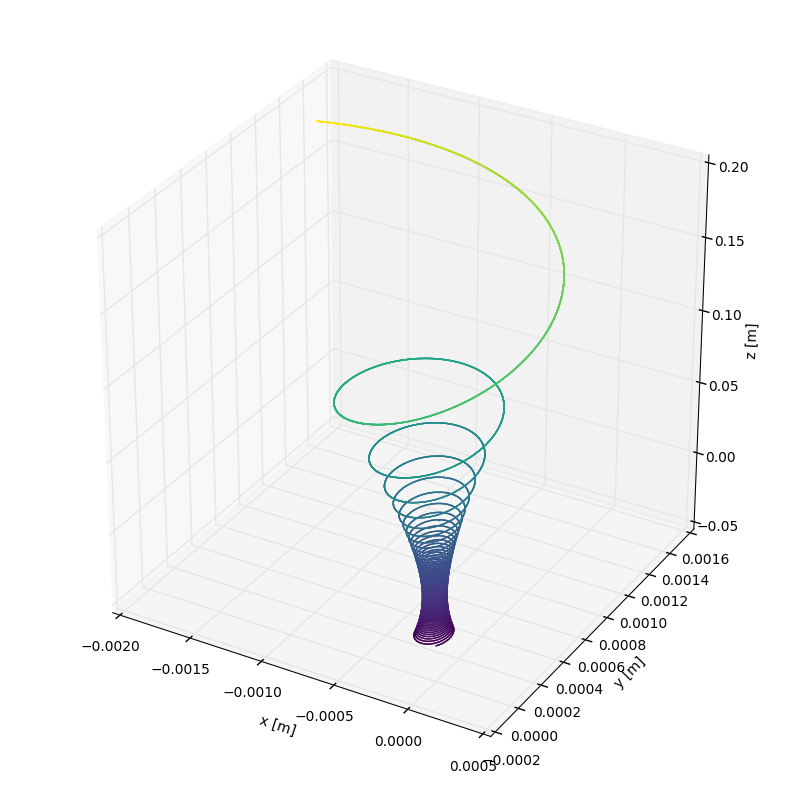

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Firstly, we initialize the figure and the only thing we specify are its dimensions
fig = plt.figure(figsize=(10,10))
# Then, we create coordinate axes and by passing the projection='3d' keyword argument, we tell matplotlib
# that we will be making a 3D picture. If we need to make any modifications to the axes later,
# we will be modifying the "ax" object.
ax = fig.gca(projection='3d') 

# Here we Have to take a slightly different approach, we will draw each segment of the line one by one
# using a plot group and for each of these segments, we use a different color.
N = len(results[:,2])
for i in range(N-1):
    p = ax.plot(results[i:i+2,0], results[i:i+2,1], results[i:i+2,2], color=plt.cm.viridis(i/N))

# Here, we set axis labels
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

# And finally, we reveal the beautiful picture.
plt.show()

### Vykreslení z-souřadnice jako funkce času.

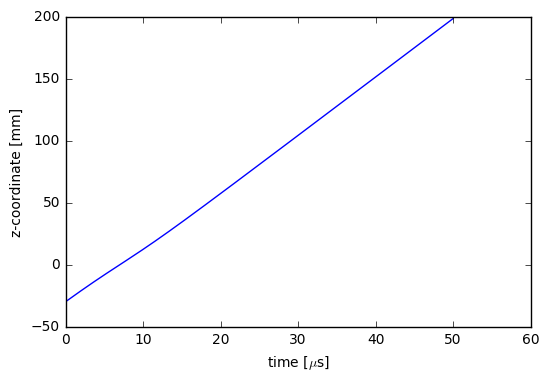

In [24]:
fig, ax = plt.subplots()
ax.plot(times*1e6, results[:,2]*1000)
ax.set_xlabel(r'time [$\mu$s]')
ax.set_ylabel('z-coordinate [mm]')

plt.show()

### Případ 2: Zrcadlo propustí

In [25]:
from scipy.integrate import ode

q0 = [0, 0, -0.03, 1000, 1000, 3500] # initial values of coordinate and velocity respectively
t0 = 0 # initial time
tf = 3e-5 # final time 
dt = 5e-9 # time step
times = np.array([t0]) # numpy array where we are going to store time steps that the simulation makes
results = np.array(q0) # numpy array where we are going to store positions and velocities.

# The following four lines are solving the differential equation 
r = ode(rhs) # We call the scipy.integrate.ode() function and pass it the rhs() function as argument
r.set_initial_value(q0, t0) # then we set initial value of the independent variables and time
# And finally, we run a while loop until we reach the final time.
while r.successful() and r.t < tf: 
    times = np.vstack([times, r.t+dt])
    results = np.vstack([results, r.integrate(r.t+dt)])

/home/ziky/.virtualenvs/plasmasolve3/lib/python3.4/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


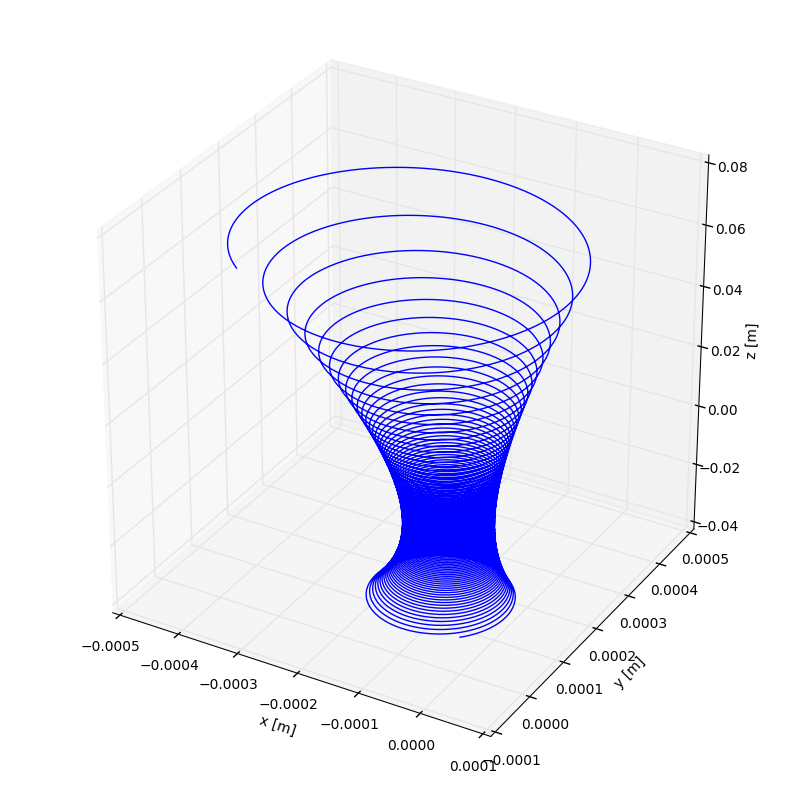

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Firstly, we initialize the figure and the only thing we specify are its dimensions
fig = plt.figure(figsize=(10,10))
# Then, we create coordinate axes and by passing the projection='3d' keyword argument, we tell matplotlib
# that we will be making a 3D picture. If we need to make any modifications to the axes later,
# we will be modifying the "ax" object.
ax = fig.gca(projection='3d') 
# Now that matplotlib knows that we are going to plot 3D data, we can call our
# usual plot() function, but instead of pasing it (x,y) data, we pass it (x,y,z) data, very simple.
plt.plot(results[:,0], results[:,1], results[:,2]) 

# Here, we set axis labels
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

# And finally, we reveal the beautiful picture.
plt.show()

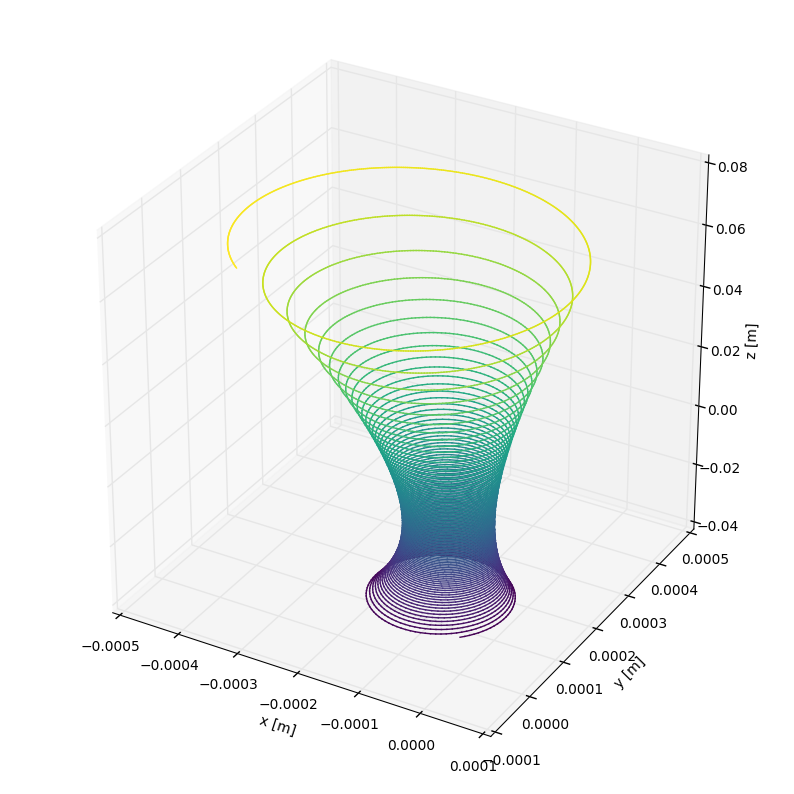

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Firstly, we initialize the figure and the only thing we specify are its dimensions
fig = plt.figure(figsize=(10,10))
# Then, we create coordinate axes and by passing the projection='3d' keyword argument, we tell matplotlib
# that we will be making a 3D picture. If we need to make any modifications to the axes later,
# we will be modifying the "ax" object.
ax = fig.gca(projection='3d') 

# Here we Have to take a slightly different approach, we will draw each segment of the line one by one
# using a plot group and for each of these segments, we use a different color.
N = len(results[:,2])
for i in range(N-1):
    ax.plot(results[i:i+2,0], results[i:i+2,1], results[i:i+2,2], color=plt.cm.viridis(i/N))

# Here, we set axis labels
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')

# And finally, we reveal the beautiful picture.
plt.show()

## Bonus: animace

In [28]:
from tempfile import NamedTemporaryFile
import base64 
from matplotlib import animation
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        f = NamedTemporaryFile(suffix='.mp4', delete=False)
        anim.save(f.name, fps=45, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
        f.flush()
        video = open(f.name, "rb").read()
        f.close()
        anim._encoded_video = base64.b64encode(video).decode('utf-8')
    
    return VIDEO_TAG.format(anim._encoded_video)

In [29]:
from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [30]:
FRAMES = 1000
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)


def init():
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax2.set_ylim([-0.03, -0.01])
    ax2.set_xlabel(r'time [$\mu$s]')
    ax2.set_ylabel(r'z-coordinate [m]')
    
# animation function.  This is called sequentially
def animate(i):
    current_index = int(results.shape[0] / FRAMES * i)
    ax.cla()
    ax.plot3D(results[:current_index, 0], 
              results[:current_index, 1], 
              results[:current_index, 2])
    ax.plot3D(results[current_index-1:current_index, 0], 
              results[current_index-1:current_index, 1], 
              results[current_index-1:current_index, 2], 'ro')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim([-0.0003, 0.0001])
    ax.set_ylim([-0.0003, 0.0003])
    ax.set_zlim([-0.03, -0.01])
    
    ax2.plot(times[:current_index]/1e6, results[:current_index, 2], 'b-')
    ax2.set_xlim([np.min(times)/1e6, np.max(times)/1e6])
    ax2.set_ylim([-0.03, -0.01])
    ax2.set_xlabel(r'time [$\mu$s]')
    ax2.set_ylabel(r'z-coordinate [m]')
    
    
# call the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=FRAMES, interval=100)

# call our new function to display the animation
display_animation(anim)